In [17]:
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

from tensorflow.keras.utils import to_categorical

import numpy as np
import nltk
import matplotlib.pyplot as plt
import random

In [18]:
#load and clean data
raw = open("data.txt", "r")

lines = []
for line in raw:
    if str(line) != '\n':
        lines.append(str(line))

#putting the entirety of the input data into one string
text = ""
for line in lines:
    text += line
tokenized = nltk.word_tokenize(text)

#converting the text into numbers to be processed by the embedding layer of the model
words = [] #one of each word in tokenized will be in here
filtering = lambda x : not x in words #for finding if the word should be added to the words array
find = lambda x : words.index(x) if x in words else -1 #convert each word into a number. -1 means that the item isn't in the vocabulary

for word in tokenized:
    if filtering(word):
        words.append(word)

#x data is every single word in the data set, in order
#y data is every single word that comes after the corresponding x value
x = []
y = []
for i in range(len(tokenized)):
    x.append(find(tokenized[i]))
    if i+1 < len(tokenized):
        y.append(find(tokenized[i+1]))
    else:
        y.append(find("."))

x = np.asarray(x)
y = np.asarray(y)
y = to_categorical(y)

print(x.shape)
print(y.shape)

vocab_size = len(words) + 1

(24496,)
(24496, 4198)


In [20]:
#create and compile model
model = Sequential()

model.add(Embedding(vocab_size, 64, input_length=(1))) #embedding: size of vocabulary, dimension of each value
model.add(LSTM(40))
model.add(Dropout(0.05))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.05))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 64)             268736    
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                16800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1312      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4198)              138534    
Total params: 425,382
Trainable params: 425,382
Non-trainable params: 0
________________________________________________

Epoch 1/5
2450/2450 [==============================] - 25s 10ms/step - loss: 6.1277 - accuracy: 0.0940
Epoch 2/5
2450/2450 [==============================] - 25s 10ms/step - loss: 5.8876 - accuracy: 0.1030
Epoch 3/5
2450/2450 [==============================] - 25s 10ms/step - loss: 5.6604 - accuracy: 0.1139
Epoch 4/5
2450/2450 [==============================] - 24s 10ms/step - loss: 5.4382 - accuracy: 0.1272
Epoch 5/5
2450/2450 [==============================] - 24s 10ms/step - loss: 5.2466 - accuracy: 0.1402


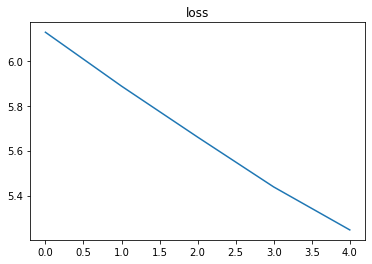

In [22]:
#train model
hist = model.fit(x, y, epochs=5, verbose=1, batch_size=10)
plt.title("loss")
plt.plot(hist.history['loss'])
#model.save("shakespear2.0.h5")

In [25]:
#test model
sample_length = 40
#model = load_model("shakespear2.0.h5")

root = random.choice(words)
output = ""

for i in range(sample_length):
    num = find(root)
    pred = model.predict([num])
    output += words[pred.argmax()] + " "
    root = words[pred.argmax()] #setting the next word

print(output)

or love , And I , And I , And I , And I , And I , And I , And I , And I , And I , And I , And I , And I , And 
